# Buddy-Buddy classifier

# 0. 초기세팅, 모듈 설치

In [2]:
import warnings

warnings.filterwarnings(action='ignore')

In [ ]:
pip install pandas

In [ ]:
pip install geopy

In [ ]:
pip install numpy

In [ ]:
pip install folium

In [ ]:
pip install scikit-learn

In [ ]:
pip install matplotlib

In [ ]:
pip install openpyxl

In [ ]:
pip install pulp

# 1. 데이터 입력, 경위도 변환

### 데이터 불러오기

In [ ]:
# csv 파일 (이름, 파트, 주소)
import pandas as pd

buddySet = pd.read_csv("./YB.csv")

buddySet

### 경위도 변환 함수

### 주소, 경위도 변환 
#### - 라이브러리가 주소를 못찾을 시 해당 컬럼 직접 수정 필요함

In [37]:
import requests, json

def get_location(address):
  url = 'https://dapi.kakao.com/v2/local/search/address.json?query=' + address
  headers = {"Authorization": "KakaoAK c550c27b304a1c785fd432b138514c45"}
  api_json = json.loads(str(requests.get(url,headers=headers).text))
  address = api_json['documents'][0]['address']
  x_y = [float(address['y']), float(address['x'])]

  return x_y

In [38]:
latitudeSet = []
longtitudeSet = []
failed_address = []

locations = buddySet['주소'].astype(str)

for idx, location in enumerate(locations):
    try:
        x_y = get_location(location)
        latitudeSet.append(x_y[0])
        longtitudeSet.append(x_y[1])
    except:
        print('주솟값 변환 실패: 직접 변경 필요')
        failed_address.append(idx)
        pass

if(len(failed_address) > 0):
    print('------------------------')
    print('주소값 변환 실패 리스트')
    for failed_idx in failed_address:
        print("순번:", (failed_idx + 2), " 이름:", buddySet.loc[failed_idx, '이름'])

### 경위도 변환 결과 확인

In [ ]:
buddySet['위도'] = latitudeSet
buddySet['경도'] = longtitudeSet

buddySet

### 결측치 확인

In [40]:
import numpy as np

buddySet.isin([np.nan, np.inf]).sum()

파트    0
이름    0
주소    0
위도    0
경도    0
dtype: int64

# 2. 경위도 위치 분포 시각화

### 1. marker

In [ ]:
from folium.plugins import MarkerCluster
import folium

latitude, longitude = 37.56100278, 126.9996417
s_korea = folium.Map(location = [latitude, longitude], zoom_start=10)

marker_map = MarkerCluster().add_to(s_korea)

for lat, long, name in zip(buddySet['위도'], buddySet['경도'], buddySet['이름']):
    folium.Marker([lat, long], popup = name, icon = folium.Icon(color="blue")).add_to(marker_map)
    
s_korea

### 2. heat-map

In [ ]:
import folium
from folium import plugins

latitude, longitude = 37.56100278, 126.9996417
s_korea = folium.Map(location = [latitude, longitude], zoom_start=10)

s_korea.add_child(plugins.HeatMap(zip(buddySet['위도'],
                                      buddySet['경도']), radius=8))
s_korea

# 3. Buddy Buddy 클러스터링

## 클러스터링

In [ ]:
buddySet

In [44]:
buddySet[['위도','경도']]

,위도,경도
0,37.555477,127.075351
1,37.593989,127.020418
2,37.652548,127.077502
3,37.675198,126.750669
4,37.493012,126.914942
...,...,...
128,37.303686,127.046372
129,37.416588,127.199517
130,37.498516,126.939014
131,37.388549,127.110871


In [45]:
clusterSet = buddySet[['위도','경도']]
clusterSet2 = clusterSet.reset_index(drop=True, inplace=True)
clusterSet2

In [46]:
#!/usr/bin/env python3.5
# coding: utf-8

import pulp
import random
import argparse

def l2_distance(point1, point2):
    return sum([(float(i)-float(j))**2 for (i,j) in zip(point1, point2)])

class subproblem(object):
    def __init__(self, centroids, data, min_size, max_size):

        self.centroids = centroids
        self.data = data
        self.min_size = min_size
        self.max_size= max_size
        self.n = len(data)
        self.k = len(centroids)

        self.create_model()

    def create_model(self):
        def distances(assignment):
            return l2_distance(self.data[assignment[0]], self.centroids[assignment[1]])

        clusters = list(range(self.k))
        assignments = [(i, j)for i in range(self.n) for j in range(self.k)]

        # outflow variables for data nodes
        self.y = pulp.LpVariable.dicts('data-to-cluster assignments',
                                  assignments,
                                  lowBound=0,
                                  upBound=1,
                                  cat=pulp.LpInteger)

        # outflow variables for cluster nodes
        self.b = pulp.LpVariable.dicts('cluster outflows',
                                  clusters,
                                  lowBound=0,
                                  upBound=self.n-self.min_size,
                                  cat=pulp.LpContinuous)

        # create the model
        self.model = pulp.LpProblem("Model for assignment subproblem", pulp.LpMinimize)

        # objective function
        self.model += pulp.lpSum([distances(assignment) * self.y[assignment] for assignment in assignments])

        # flow balance constraints for data nodes
        for i in range(self.n):
            self.model += pulp.lpSum(self.y[(i, j)] for j in range(self.k)) == 1

        # flow balance constraints for cluster nodes
        for j in range(self.k):
            self.model += pulp.lpSum(self.y[(i, j)] for i in range(self.n)) - self.min_size == self.b[j]
            
        # capacity constraint on outflow of cluster nodes
        for j in range(self.k):
            self.model += self.b[j] <= self.max_size - self.min_size 

        # flow balance constraint for the sink node
        self.model += pulp.lpSum(self.b[j] for j in range(self.k)) == self.n - (self.k * self.min_size)


    def solve(self):
        self.status = self.model.solve()

        clusters = None
        if self.status == 1:
            clusters= [-1 for i in range(self.n)]
            for i in range(self.n):
                for j in range(self.k):
                    if self.y[(i, j)].value() > 0:
                        clusters[i] = j
        return clusters

def initialize_centers(dataset, k):
    ids = list(range(len(dataset)))
    random.shuffle(ids)
    return [dataset[id] for id in ids[:k]]

def compute_centers(clusters, dataset):
    # canonical labeling of clusters
    ids = list(set(clusters))
    c_to_id = dict()
    for j, c in enumerate(ids):
        c_to_id[c] = j
    for j, c in enumerate(clusters):
        clusters[j] = c_to_id[c]

    k = len(ids)
    dim = len(dataset[0])
    centers = [[0.0] * dim for i in range(k)]
    counts = [0] * k
    for j, c in enumerate(clusters):
        for i in range(dim):
            centers[c][i] += dataset[j][i]
        counts[c] += 1
    for j in range(k):
        for i in range(dim):
            centers[j][i] = centers[j][i]/float(counts[j])
    return clusters, centers

def minsize_kmeans(dataset, k, min_size=0, max_size=None):
    n = len(dataset)
    if max_size == None:
        max_size = n

    centers = initialize_centers(dataset, k)
    clusters = [-1] * n

    converged = False
    while not converged:
        m = subproblem(centers, dataset, min_size, max_size)
        clusters_ = m.solve()
        if not clusters_:
            return None, None
        clusters_, centers = compute_centers(clusters_, dataset)

        converged = True
        i = 0
        while converged and i < len(dataset):
            if clusters[i] != clusters_[i]:
                converged = False
            i += 1
        clusters = clusters_

    return clusters, centers

def cluster_quality(cluster):
    if len(cluster) == 0:
        return 0.0

    quality = 0.0
    for i in range(len(cluster)):
        for j in range(i, len(cluster)):
            quality += l2_distance(cluster[i], cluster[j])
    return quality / len(cluster)

def compute_quality(data, cluster_indices):
    clusters = dict()
    for i, c in enumerate(cluster_indices):
        if c in clusters:
            clusters[c].append(data[i])
        else:
            clusters[c] = [data[i]]
    return sum(cluster_quality(c) for c in clusters.values())


In [47]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, silhouette_samples

X_features = buddySet[['위도', '경도']]

from sklearn.preprocessing import StandardScaler

X_features_scaled = StandardScaler().fit_transform(X_features)

In [48]:
X_features_scaled

array([[ 3.28510408e-01,  7.38721647e-01],
       [ 6.43593687e-01,  3.28533826e-01],
       [ 1.12267644e+00,  7.54785878e-01],
       [ 1.30798574e+00, -1.68569960e+00],
       [-1.82524806e-01, -4.59062936e-01],
       [-1.37496653e-01, -2.79313264e-01],
       [-1.12169202e+00,  1.13307853e+00],
       [-1.92208199e+00,  1.03271039e+00],
       [ 3.22900456e-01, -8.93500293e-02],
       [ 3.54769425e-01, -3.15309026e-01],
       [-4.78452277e-01, -6.04559831e-01],
       [-1.06417303e+00,  2.32629449e+00],
       [-1.82532692e-01, -8.86144728e-01],
       [ 8.96016702e-01,  7.27300560e-01],
       [ 1.80035827e-01, -6.50201125e-02],
       [ 1.71497513e-01, -9.51812157e-01],
       [-1.49078110e-01, -4.83138057e-01],
       [ 7.29456644e-01,  1.18355231e+00],
       [ 7.65978387e-04,  1.17894146e+00],
       [ 1.20850816e+00,  1.90187791e-01],
       [-2.13011859e-01, -1.19278514e+00],
       [-2.58352468e+00, -1.08229867e+00],
       [ 6.56794367e-01,  1.80272974e+00],
       [ 8.

In [58]:
#data set    
data = X_features_scaled

#number of clusters    
k = 32

#min size
min_size = 4

#max size
max_size = 5

#run the algorithm for NUM_ITER times and return the best clustering
NUM_ITER = 9

best = None
best_clusters = None
for i in range(NUM_ITER):
    clusters, centers = minsize_kmeans(data, k, min_size, max_size)
    if clusters:
        quality = compute_quality(data, clusters)
    if not best or (quality < best):
        best = quality
        best_clusters = clusters

groupSet = pd.DataFrame(columns=['조'])

if best:
    print('cluster assignments:')
    for i in range(len(best_clusters)):
        print(best_clusters[i])
        groupSet = groupSet.append({'조': best_clusters[i]}, ignore_index=True)
    print('sum of squared distances: %.4f'%(best))
else:
    print('no clustering found')




Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /opt/homebrew/lib/python3.11/site-packages/pulp/solverdir/cbc/osx/64/cbc /var/folders/78/nskjw12s4tjd5g43cgbrwt9h0000gn/T/c13090023ab1416cb7b6e55996a2c1dd-pulp.mps timeMode elapsed branch printingOptions all solution /var/folders/78/nskjw12s4tjd5g43cgbrwt9h0000gn/T/c13090023ab1416cb7b6e55996a2c1dd-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 203 COLUMNS
At line 21520 RHS
At line 21719 BOUNDS
At line 26008 ENDATA
Problem MODEL has 198 rows, 4288 columns and 8608 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Continuous objective value is 55.5453 - 0.01 seconds
Cgl0005I 133 SOS with 4256 members
Cgl0004I processed model has 166 rows, 4288 columns (4288 integer (4288 of which binary)) and 8576 elements
Cbc0038I Initial state - 0 integers unsatisfied sum - 0
Cbc0038I Solution found of 55.5453
Cbc0038I Before mini branch

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /opt/homebrew/lib/python3.11/site-packages/pulp/solverdir/cbc/osx/64/cbc /var/folders/78/nskjw12s4tjd5g43cgbrwt9h0000gn/T/dc6be8a917e64648a8c5741d35fa5c64-pulp.mps timeMode elapsed branch printingOptions all solution /var/folders/78/nskjw12s4tjd5g43cgbrwt9h0000gn/T/dc6be8a917e64648a8c5741d35fa5c64-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 203 COLUMNS
At line 21580 RHS
At line 21779 BOUNDS
At line 26068 ENDATA
Problem MODEL has 198 rows, 4288 columns and 8608 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Continuous objective value is 12.4173 - 0.01 seconds
Cgl0005I 133 SOS with 4256 members
Cgl0004I processed model has 166 rows, 4288 columns (4288 integer (4288 of which binary)) and 8576 elements
Cbc0038I Initial state - 0 integers unsatisfied sum - 0
Cbc0038I Solution found of 12.4173
Cbc0038I Before mini branch

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /opt/homebrew/lib/python3.11/site-packages/pulp/solverdir/cbc/osx/64/cbc /var/folders/78/nskjw12s4tjd5g43cgbrwt9h0000gn/T/d133b9ded2044e2d8f82fc8ecc62d03c-pulp.mps timeMode elapsed branch printingOptions all solution /var/folders/78/nskjw12s4tjd5g43cgbrwt9h0000gn/T/d133b9ded2044e2d8f82fc8ecc62d03c-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 203 COLUMNS
At line 21580 RHS
At line 21779 BOUNDS
At line 26068 ENDATA
Problem MODEL has 198 rows, 4288 columns and 8608 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Continuous objective value is 16.5473 - 0.01 seconds
Cgl0005I 133 SOS with 4256 members
Cgl0004I processed model has 166 rows, 4288 columns (4288 integer (4288 of which binary)) and 8576 elements
Cbc0038I Initial state - 0 integers unsatisfied sum - 0
Cbc0038I Solution found of 16.5473
Cbc0038I Before mini branch

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /opt/homebrew/lib/python3.11/site-packages/pulp/solverdir/cbc/osx/64/cbc /var/folders/78/nskjw12s4tjd5g43cgbrwt9h0000gn/T/54e8a9e1c5ae40ed848b5fad041e6a99-pulp.mps timeMode elapsed branch printingOptions all solution /var/folders/78/nskjw12s4tjd5g43cgbrwt9h0000gn/T/54e8a9e1c5ae40ed848b5fad041e6a99-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 203 COLUMNS
At line 21575 RHS
At line 21774 BOUNDS
At line 26063 ENDATA
Problem MODEL has 198 rows, 4288 columns and 8608 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Continuous objective value is 12.812 - 0.01 seconds
Cgl0005I 133 SOS with 4256 members
Cgl0004I processed model has 166 rows, 4288 columns (4288 integer (4288 of which binary)) and 8576 elements
Cbc0038I Initial state - 0 integers unsatisfied sum - 0
Cbc0038I Solution found of 12.812
Cbc0038I Before mini branch a

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /opt/homebrew/lib/python3.11/site-packages/pulp/solverdir/cbc/osx/64/cbc /var/folders/78/nskjw12s4tjd5g43cgbrwt9h0000gn/T/23f2a9531526467fa24766d270c1190d-pulp.mps timeMode elapsed branch printingOptions all solution /var/folders/78/nskjw12s4tjd5g43cgbrwt9h0000gn/T/23f2a9531526467fa24766d270c1190d-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 203 COLUMNS
At line 21576 RHS
At line 21775 BOUNDS
At line 26064 ENDATA
Problem MODEL has 198 rows, 4288 columns and 8608 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Continuous objective value is 15.0187 - 0.01 seconds
Cgl0005I 133 SOS with 4256 members
Cgl0004I processed model has 166 rows, 4288 columns (4288 integer (4288 of which binary)) and 8576 elements
Cbc0038I Initial state - 0 integers unsatisfied sum - 0
Cbc0038I Solution found of 15.0187
Cbc0038I Before mini branch

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /opt/homebrew/lib/python3.11/site-packages/pulp/solverdir/cbc/osx/64/cbc /var/folders/78/nskjw12s4tjd5g43cgbrwt9h0000gn/T/05bc514d041244c99bad4cca5417f682-pulp.mps timeMode elapsed branch printingOptions all solution /var/folders/78/nskjw12s4tjd5g43cgbrwt9h0000gn/T/05bc514d041244c99bad4cca5417f682-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 203 COLUMNS
At line 21576 RHS
At line 21775 BOUNDS
At line 26064 ENDATA
Problem MODEL has 198 rows, 4288 columns and 8608 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Continuous objective value is 12.6259 - 0.01 seconds
Cgl0005I 133 SOS with 4256 members
Cgl0004I processed model has 166 rows, 4288 columns (4288 integer (4288 of which binary)) and 8576 elements
Cbc0038I Initial state - 0 integers unsatisfied sum - 0
Cbc0038I Solution found of 12.6259
Cbc0038I Before mini branch

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /opt/homebrew/lib/python3.11/site-packages/pulp/solverdir/cbc/osx/64/cbc /var/folders/78/nskjw12s4tjd5g43cgbrwt9h0000gn/T/28664470d9d14ae0afeac44599e3f34c-pulp.mps timeMode elapsed branch printingOptions all solution /var/folders/78/nskjw12s4tjd5g43cgbrwt9h0000gn/T/28664470d9d14ae0afeac44599e3f34c-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 203 COLUMNS
At line 21580 RHS
At line 21779 BOUNDS
At line 26068 ENDATA
Problem MODEL has 198 rows, 4288 columns and 8608 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Continuous objective value is 15.807 - 0.01 seconds
Cgl0005I 133 SOS with 4256 members
Cgl0004I processed model has 166 rows, 4288 columns (4288 integer (4288 of which binary)) and 8576 elements
Cbc0038I Initial state - 0 integers unsatisfied sum - 0
Cbc0038I Solution found of 15.807
Cbc0038I Before mini branch a

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /opt/homebrew/lib/python3.11/site-packages/pulp/solverdir/cbc/osx/64/cbc /var/folders/78/nskjw12s4tjd5g43cgbrwt9h0000gn/T/1b8496e835ad4b45827e865ab8adeb63-pulp.mps timeMode elapsed branch printingOptions all solution /var/folders/78/nskjw12s4tjd5g43cgbrwt9h0000gn/T/1b8496e835ad4b45827e865ab8adeb63-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 203 COLUMNS
At line 21530 RHS
At line 21729 BOUNDS
At line 26018 ENDATA
Problem MODEL has 198 rows, 4288 columns and 8608 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Continuous objective value is 28.5991 - 0.01 seconds
Cgl0005I 133 SOS with 4256 members
Cgl0004I processed model has 166 rows, 4288 columns (4288 integer (4288 of which binary)) and 8576 elements
Cbc0038I Initial state - 0 integers unsatisfied sum - 0
Cbc0038I Solution found of 28.5991
Cbc0038I Before mini branch

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /opt/homebrew/lib/python3.11/site-packages/pulp/solverdir/cbc/osx/64/cbc /var/folders/78/nskjw12s4tjd5g43cgbrwt9h0000gn/T/cef2c155fa2946599eb88acc7849cb0a-pulp.mps timeMode elapsed branch printingOptions all solution /var/folders/78/nskjw12s4tjd5g43cgbrwt9h0000gn/T/cef2c155fa2946599eb88acc7849cb0a-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 203 COLUMNS
At line 21575 RHS
At line 21774 BOUNDS
At line 26063 ENDATA
Problem MODEL has 198 rows, 4288 columns and 8608 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Continuous objective value is 14.0156 - 0.00 seconds
Cgl0005I 133 SOS with 4256 members
Cgl0004I processed model has 166 rows, 4288 columns (4288 integer (4288 of which binary)) and 8576 elements
Cbc0038I Initial state - 0 integers unsatisfied sum - 0
Cbc0038I Solution found of 14.0156
Cbc0038I Before mini branch

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /opt/homebrew/lib/python3.11/site-packages/pulp/solverdir/cbc/osx/64/cbc /var/folders/78/nskjw12s4tjd5g43cgbrwt9h0000gn/T/47949ea6caeb4ace9f0c29e7eaa95a09-pulp.mps timeMode elapsed branch printingOptions all solution /var/folders/78/nskjw12s4tjd5g43cgbrwt9h0000gn/T/47949ea6caeb4ace9f0c29e7eaa95a09-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 203 COLUMNS
At line 21576 RHS
At line 21775 BOUNDS
At line 26064 ENDATA
Problem MODEL has 198 rows, 4288 columns and 8608 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Continuous objective value is 16.2604 - 0.01 seconds
Cgl0005I 133 SOS with 4256 members
Cgl0004I processed model has 166 rows, 4288 columns (4288 integer (4288 of which binary)) and 8576 elements
Cbc0038I Initial state - 0 integers unsatisfied sum - 0
Cbc0038I Solution found of 16.2604
Cbc0038I Before mini branch

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /opt/homebrew/lib/python3.11/site-packages/pulp/solverdir/cbc/osx/64/cbc /var/folders/78/nskjw12s4tjd5g43cgbrwt9h0000gn/T/f05870b178654c5eb1ecda35f6cb58cb-pulp.mps timeMode elapsed branch printingOptions all solution /var/folders/78/nskjw12s4tjd5g43cgbrwt9h0000gn/T/f05870b178654c5eb1ecda35f6cb58cb-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 203 COLUMNS
At line 21580 RHS
At line 21779 BOUNDS
At line 26068 ENDATA
Problem MODEL has 198 rows, 4288 columns and 8608 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Continuous objective value is 14.3646 - 0.01 seconds
Cgl0005I 133 SOS with 4256 members
Cgl0004I processed model has 166 rows, 4288 columns (4288 integer (4288 of which binary)) and 8576 elements
Cbc0038I Initial state - 0 integers unsatisfied sum - 0
Cbc0038I Solution found of 14.3646
Cbc0038I Before mini branch

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /opt/homebrew/lib/python3.11/site-packages/pulp/solverdir/cbc/osx/64/cbc /var/folders/78/nskjw12s4tjd5g43cgbrwt9h0000gn/T/1f5edff59e634915aefaf33257565cd7-pulp.mps timeMode elapsed branch printingOptions all solution /var/folders/78/nskjw12s4tjd5g43cgbrwt9h0000gn/T/1f5edff59e634915aefaf33257565cd7-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 203 COLUMNS
At line 21530 RHS
At line 21729 BOUNDS
At line 26018 ENDATA
Problem MODEL has 198 rows, 4288 columns and 8608 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Continuous objective value is 72.0258 - 0.01 seconds
Cgl0005I 133 SOS with 4256 members
Cgl0004I processed model has 166 rows, 4288 columns (4288 integer (4288 of which binary)) and 8576 elements
Cbc0038I Initial state - 0 integers unsatisfied sum - 0
Cbc0038I Solution found of 72.0258
Cbc0038I Before mini branch

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /opt/homebrew/lib/python3.11/site-packages/pulp/solverdir/cbc/osx/64/cbc /var/folders/78/nskjw12s4tjd5g43cgbrwt9h0000gn/T/74ca9e1c5ce442f18b6497e407e20597-pulp.mps timeMode elapsed branch printingOptions all solution /var/folders/78/nskjw12s4tjd5g43cgbrwt9h0000gn/T/74ca9e1c5ce442f18b6497e407e20597-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 203 COLUMNS
At line 21576 RHS
At line 21775 BOUNDS
At line 26064 ENDATA
Problem MODEL has 198 rows, 4288 columns and 8608 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Continuous objective value is 13.1426 - 0.01 seconds
Cgl0005I 133 SOS with 4256 members
Cgl0004I processed model has 166 rows, 4288 columns (4288 integer (4288 of which binary)) and 8576 elements
Cbc0038I Initial state - 0 integers unsatisfied sum - 0
Cbc0038I Solution found of 13.1426
Cbc0038I Before mini branch

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /opt/homebrew/lib/python3.11/site-packages/pulp/solverdir/cbc/osx/64/cbc /var/folders/78/nskjw12s4tjd5g43cgbrwt9h0000gn/T/5e215e531710494ea58f158852ead29c-pulp.mps timeMode elapsed branch printingOptions all solution /var/folders/78/nskjw12s4tjd5g43cgbrwt9h0000gn/T/5e215e531710494ea58f158852ead29c-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 203 COLUMNS
At line 21580 RHS
At line 21779 BOUNDS
At line 26068 ENDATA
Problem MODEL has 198 rows, 4288 columns and 8608 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Continuous objective value is 13.421 - 0.01 seconds
Cgl0005I 133 SOS with 4256 members
Cgl0004I processed model has 166 rows, 4288 columns (4288 integer (4288 of which binary)) and 8576 elements
Cbc0038I Initial state - 0 integers unsatisfied sum - 0
Cbc0038I Solution found of 13.421
Cbc0038I Before mini branch a

In [59]:
groupSet

,조
0,7
1,31
2,10
3,29
4,1
...,...
128,6
129,26
130,1
131,22


## n 클러스터 시각화

In [60]:
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import cm

cm.jet(1/4)

def clusterScatter(n_cluster, X_features): 
    c_colors = []
    kmeans = KMeans(n_clusters=n_cluster, random_state=0)
    Y_labels = kmeans.fit_predict(X_features)

    for i in range(n_cluster):
        c_color = cm.jet(float(i) / n_cluster) 
        c_colors.append(c_color)
        plt.scatter(X_features[Y_labels == i,0], X_features[Y_labels == i,1],
                     marker='o', color=c_color, edgecolor='black', s=50, 
                     label='cluster '+ str(i))       

    for i in range(n_cluster):
        plt.scatter(kmeans.cluster_centers_[i,0], kmeans.cluster_centers_[i,1], 
                    marker='^', color=c_colors[i], edgecolor='w', s=200)
        
    plt.legend()
    plt.grid()
    plt.tight_layout()
    plt.show()

## k 값은 지역구 분류 기준의 개수 

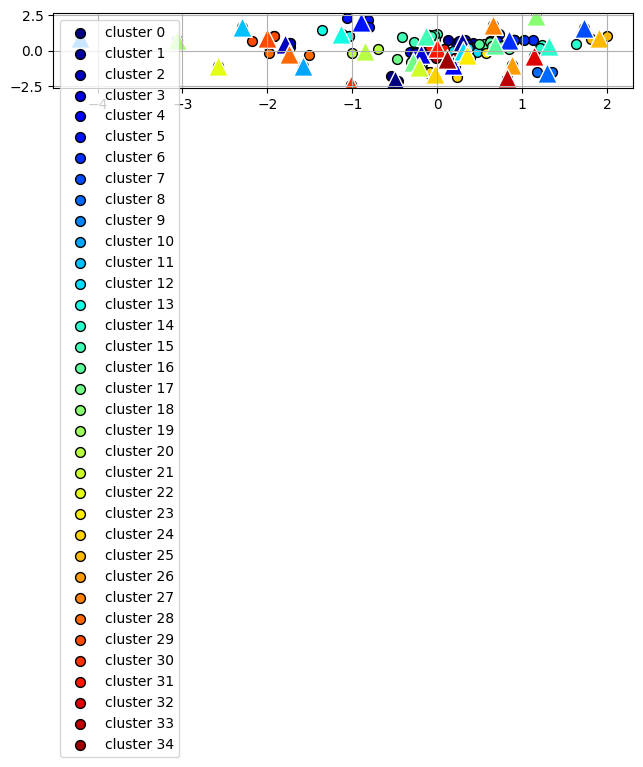

In [61]:
clusterScatter(35, X_features_scaled) 

## 성능 평가

In [62]:
from matplotlib import cm

def silhouetteViz(n_cluster, X_features): 
    
    kmeans = KMeans(n_clusters=n_cluster, random_state=0)
    Y_labels = kmeans.fit_predict(X_features)
    
    silhouette_values = silhouette_samples(X_features, Y_labels, metric='euclidean')

    y_ax_lower, y_ax_upper = 0, 0
    y_ticks = []

    for c in range(n_cluster):
        c_silhouettes = silhouette_values[Y_labels == c]
        c_silhouettes.sort()
        y_ax_upper += len(c_silhouettes)
        color = cm.jet(float(c) / n_cluster)
        plt.barh(range(y_ax_lower, y_ax_upper), c_silhouettes,
                 height=1.0, edgecolor='none', color=color)
        y_ticks.append((y_ax_lower + y_ax_upper) / 2.)
        y_ax_lower += len(c_silhouettes)
    
    silhouette_avg = np.mean(silhouette_values)
    plt.axvline(silhouette_avg, color='red', linestyle='--')
    plt.title('Number of Cluster : '+ str(n_cluster)+'\n' \
              + 'Silhouette Score : '+ str(round(silhouette_avg,3)))
    plt.yticks(y_ticks, range(n_cluster))   
    plt.xticks([0, 0.2, 0.4, 0.6, 0.8, 1])
    plt.ylabel('Cluster')
    plt.xlabel('Silhouette coefficient')
    plt.tight_layout()
    plt.show()

### silhouette Score를 확인한다

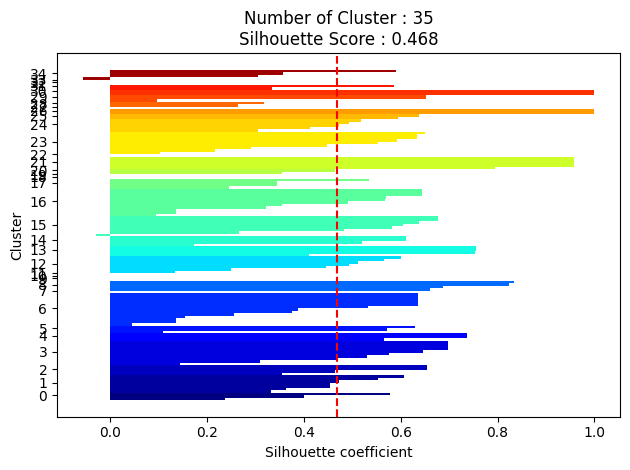

In [63]:
silhouetteViz(35, X_features_scaled)

## 클러스터링 진행

In [ ]:
buddySet['조'] = groupSet
buddySet

## 분류 시각화

In [65]:
import numpy as np

colors = np.random.randint(0, 255, size=(40, 3))

color = ['#{:02X}{:02X}{:02X}'.format(*c) for c in colors]

colorSet = ['red', 'blue', 'green', 'purple', 'orange', 'darkred', 'lightred', 'beige', 'darkblue', 'darkgreen', 'cadetblue', 'darkpurple', 'pink', 'lightblue', 'lightgreen', 'gray', 'black', 'lightgray', 'white', 'red', 'blue', 'green', 'purple', 'orange', 'darkred', 'lightred', 'beige', 'darkblue', 'darkgreen', 'cadetblue', 'darkpurple', 'pink', 'lightblue', 'lightgreen', 'gray', 'black', 'lightgray', 'white']


In [ ]:
from folium import Map, Marker, Icon

latitude, longitude = 37.56100278, 126.9996417
s_korea = folium.Map(location = [latitude, longitude], zoom_start=11)

for i in range(len(buddySet)):
    groupLabel = buddySet['조'][i]
    name = buddySet['이름'][i]
    part = buddySet['파트'][i]
    oldYoung = 'YB'
    identify = "(" + oldYoung + ")" + part + ": " + name
    
    icon = folium.Icon(color=colorSet[groupLabel], icon_color=color[groupLabel], icon_size=(35, 40))
    
    folium.Marker(location = (buddySet['위도'][i],buddySet['경도'][i]), popup = folium.Popup(identify, max_width=200), icon= icon).add_to(s_korea)

s_korea

## 대분류 결과 (n 분류의 개수)

In [ ]:
import math

n = 35
num = 1;
count = 0;

result = pd.DataFrame(columns=['이름', '파트', '주소','조'])

for i in range(n):
    clusterSet = buddySet[buddySet['조']==i]
    clusterLen = len(clusterSet)
    
    print("=============================================")
    print(num,"조")
    print(clusterSet[['이름', '파트', '주소']])
    result = result.append(clusterSet[['이름', '파트', '주소']], ignore_index=True)
    result['조'][count:count+clusterLen] = num
    num = num + 1    
    count = count + clusterLen 

In [ ]:
result

In [69]:
result.to_excel('result_YB.xlsx', index=False)